#### **DATA 622 - Assignment 3 - Decision Trees vs Support Vector Machines**

Author: Kory Martin     
Date: 4/27/2024


**Instructions:**

Pre-work:  
- Read the following articles:  
    - https://www.hindawi.com/journals/complexity/2021/5550344/  
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8137961/  
- Search for academic content (at least 3 articles) that compare the use of decision trees vs SVMs in your current area of expertise. 
    - Discuss the articles provided (1 A & B, above), the 3 you chose, and how they relate to your your area of interest

Deliverables:
- Perform an analysis of the dataset used in Homework #2 using the SVM algorithm.  
- Compare the results with the results from previous homework.  
    - Answer questions, such as:  
        - Which algorithm is recommended to get more accurate results?  
        - Is it better for classification or regression scenarios?  
        - Do you agree with the recommendations?  
        - Why?  

#### **1. Import Libraries**

In [1]:
import pandas as pd
from plotnine import *
from datetime import datetime as dt
import re

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#### **2. Import Data**

For this assignment, I pulled the [eCommerce Customer Service Satisfaction](https://www.kaggle.com/datasets/ddosad/ecommerce-customer-service-satisfaction) data from Kaggle. This dataset provides a list of customer satisfaction scores and information for various customer inquiries. The output variable that we will use for this assignment is the final CSAT score that the user gave the support agent. 

Given the richness of the dataset, our goal will be to build a model that can predict the CSAT score based on the input features.

In [3]:
cust_satisfaction_df = pd.read_csv('Customer_support_data.csv')

#### **3. Exploratory Analysis**

In [4]:
cust_satisfaction_df.shape

(85907, 20)

We see that the dataset has 85K rows and 20 different fields, which are a mix of data types including dates, strings and categorical variables. When we look at the first few rows of the data, we also notice that there are NA values in the data, and also there are some variables that are specific to the data in the row, but that we would assume may not have much generalizable characteristics that would make it worth keeping in our final data table

In [5]:
cust_satisfaction_df.head()

,Unique id,channel_name,category,Sub-category,Customer Remarks,Order_id,order_date_time,Issue_reported at,issue_responded,Survey_response_Date,Customer_City,Product_category,Item_price,connected_handling_time,Agent_name,Supervisor,Manager,Tenure Bucket,Agent Shift,CSAT Score
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,NaN,NaN,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,NaN,NaN,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,5
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,NaN,NaN,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,5
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,NaN,NaN,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,5
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,NaN,NaN,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,5


As we noticed during the previous of the table, there are at least seven fields that have NA values; with a number of these having a significant majority or near-majority of their values that are NA. ***connected_handling_time*** has only 242 non-null values.

In [6]:
cust_satisfaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85907 entries, 0 to 85906
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unique id                85907 non-null  object 
 1   channel_name             85907 non-null  object 
 2   category                 85907 non-null  object 
 3   Sub-category             85907 non-null  object 
 4   Customer Remarks         28742 non-null  object 
 5   Order_id                 67675 non-null  object 
 6   order_date_time          17214 non-null  object 
 7   Issue_reported at        85907 non-null  object 
 8   issue_responded          85907 non-null  object 
 9   Survey_response_Date     85907 non-null  object 
 10  Customer_City            17079 non-null  object 
 11  Product_category         17196 non-null  object 
 12  Item_price               17206 non-null  float64
 13  connected_handling_time  242 non-null    float64
 14  Agent_name            

I noticed that the date strings were not in a standard US date format, so went ahead and updated the strings. The thinking is that it may be valuable to create a feature that represents the amount of time between an issue being reported and when it was resolved.

In [7]:
cust_satisfaction_df['order_date'] = cust_satisfaction_df['order_date_time'].apply(lambda x: dt.strptime(str(x)[:10],'%d/%m/%Y') if not pd.isna(x) else x).copy()
cust_satisfaction_df['response_date'] = cust_satisfaction_df['issue_responded'].apply(lambda x: dt.strptime(str(x)[:16],'%d/%m/%Y %H:%M') if not pd.isna(x) else x).copy()
cust_satisfaction_df['issue_date'] = cust_satisfaction_df['Issue_reported at'].apply(lambda x: dt.strptime(str(x)[:16],'%d/%m/%Y %H:%M') if not pd.isna(x) else x).copy()


Create additional variables to evaluate the response time in days and minutes

In [8]:
cust_satisfaction_df['response_time_days'] = cust_satisfaction_df.apply(lambda x: (x['response_date']-x['issue_date']).days,axis=1)
cust_satisfaction_df['response_time_minutes'] = cust_satisfaction_df.apply(lambda x: (x['response_date']-x['issue_date']).seconds/60,axis=1)

I have a preference for consisting naming conventions for feature names, so I'm going to update the column names to a consistent format

In [9]:
col_names = [col.lower() for col in cust_satisfaction_df.columns]
col_names = [re.sub('[-\s]',"_",col) for col in col_names]
cust_satisfaction_df = cust_satisfaction_df.set_axis(col_names, axis='columns')

In [10]:
cust_satisfaction_df.head()

,unique_id,channel_name,category,sub_category,customer_remarks,order_id,order_date_time,issue_reported_at,issue_responded,survey_response_date,...,supervisor,manager,tenure_bucket,agent_shift,csat_score,order_date,response_date,issue_date,response_time_days,response_time_minutes
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,...,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,NaT,2023-08-01 11:47:00,2023-08-01 11:13:00,0,34.0
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,...,Dylan Kim,Michael Lee,>90,Morning,5,NaT,2023-08-01 12:54:00,2023-08-01 12:52:00,0,2.0
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,...,Jackson Park,William Kim,On Job Training,Evening,5,NaT,2023-08-01 20:38:00,2023-08-01 20:16:00,0,22.0
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,...,Olivia Wang,John Smith,>90,Evening,5,NaT,2023-08-01 21:16:00,2023-08-01 20:56:00,0,20.0
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,...,Austin Johnson,Michael Lee,0-30,Morning,5,NaT,2023-08-01 10:32:00,2023-08-01 10:30:00,0,2.0


Now that we've done some initial pre-processing and cleaning of the data, we can begin to explore the data and look for interesting insights that may be able to inform how we build our models. 

Some interesting questions that we can answer based on this data are:
- Are there any significant differences in CSAT score based on the categorical variables?
- Are there significant differences in the CSAT score based on the agents supervisors and managers associated with the response? 

##### *3.1 Average CSAT Score based on Channel*

In [11]:
cust_satisfaction_df.pivot_table(index=['channel_name'], values=['csat_score'])

,csat_score
channel_name,
Email,3.899107
Inbound,4.251372
Outcall,4.269909


##### *3.2 Average CSAT Score based on Customer Issue*

In [12]:
cust_satisfaction_df.pivot_table(index=['category'], values=['csat_score']).sort_values(by='csat_score',ascending=False)

,csat_score
category,
App/website,4.404762
Payments related,4.354534
Returns,4.346350
Shopzilla Related,4.306948
Onboarding related,4.261538
Refund Related,4.226813
Offers & Cashback,4.210417
Feedback,4.158675
Order Related,4.096059


In [13]:
temp_df = cust_satisfaction_df.pivot_table(index=['category'], values=['csat_score']).reset_index()

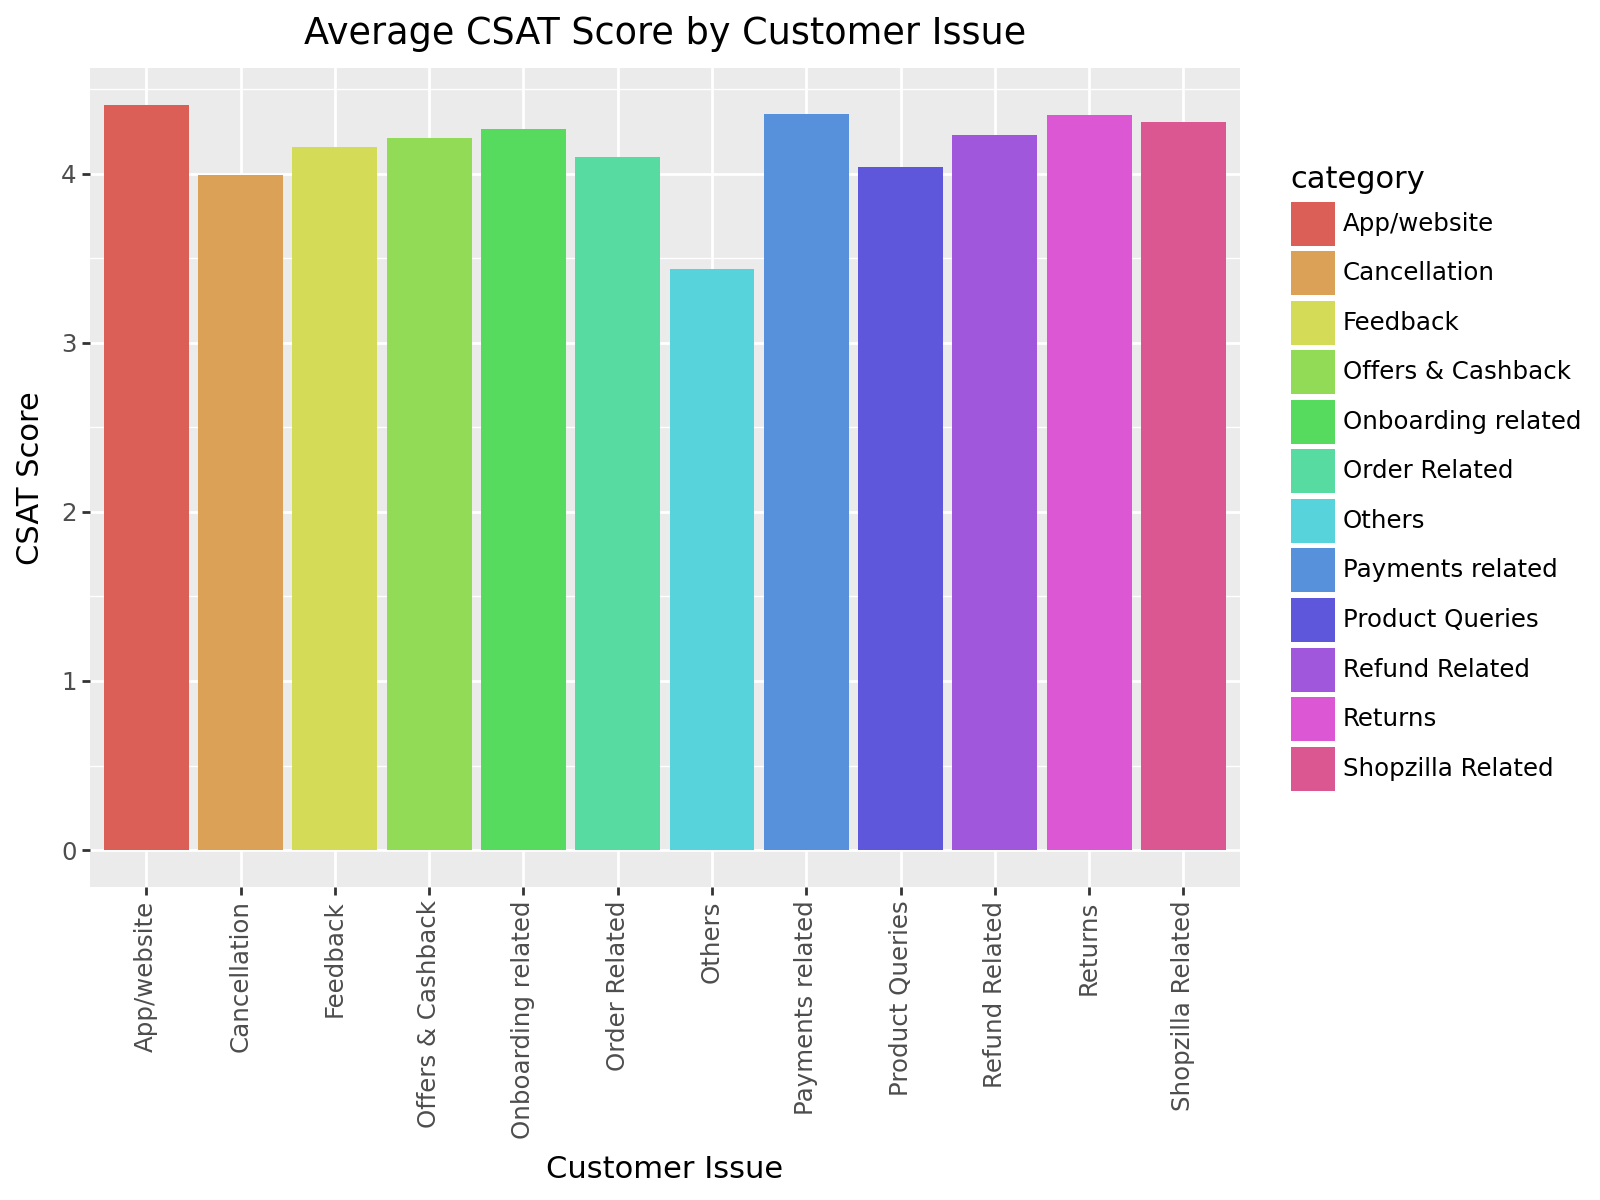

In [14]:
(
    ggplot(temp_df)
    + aes(x='category', y='csat_score', fill='category')
    + geom_bar(stat='identity')
    + theme(axis_text_x=(element_text(rotation=90)), figure_size=(8,6))
    + labs(title="Average CSAT Score by Customer Issue", y='CSAT Score', x='Customer Issue')

)


##### *3.3 Average CSAT Score based on Supervisor*

For this we look to see if there are any significant differences in the CSAT score based on the supervisor of the associated agent

In [15]:
temp_df = cust_satisfaction_df.pivot_table(index=['supervisor'], values=['csat_score']).reset_index()

In [16]:
temp_df.sort_values(by='csat_score', ascending=False).head(10)['csat_score'].mean()

4.365244769944317

In [17]:
temp_df.sort_values(by='csat_score', ascending=False).tail(10)['csat_score'].mean()

4.02003806008935

Looking at the average CSAT scores for customer inquiries for agents supervised by supervisors in the top10 of customer satisfaction scores vs. the bottom 10, we see that there's a difference in nearly 35 bps between the the two tiers or groups of agents. This suggests that there may be some differences either in the quality of leadership or possibly there may be other differences between the agents on certain teams that is evident when we evaluate the performance based on the agents supervisor

##### *3.4 Average CSAT Score based on Manager*


In [18]:
cust_satisfaction_df.pivot_table(index=['manager'], values=['csat_score']).reset_index()

,manager,csat_score
0,Emily Chen,4.379107
1,Jennifer Nguyen,4.158583
2,John Smith,4.270694
3,Michael Lee,4.259602
4,Olivia Tan,4.112193
5,William Kim,4.121032


##### *3.5 Average CSAT Score based on Tenure Bucket*


In [19]:
cust_satisfaction_df.pivot_table(index=['tenure_bucket'], values=['csat_score']).reset_index()

,tenure_bucket,csat_score
0,0-30,4.258791
1,31-60,4.296185
2,61-90,4.346536
3,>90,4.273190
4,On Job Training,4.145242


When we sort the csat score based on agent tenure, we see that CSAT Scores are lower amongst longer tenured agents vs. those who have been there between 31 and 90 days. I suspect that this is most likely due to the fact that the scores are maybe brought down by agents who have much longer tenures than 90-days, and who may be more apathetic. Additionally, it's likely that agents are on their best behavior during their 90-day probationary period, and then become a bit more relaxed once they past this threshold

In [20]:
cust_satisfaction_df.pivot_table(index=['tenure_bucket'], values=['csat_score']).\
    reset_index().sort_values(by='csat_score', ascending=False)

,tenure_bucket,csat_score
2,61-90,4.346536
1,31-60,4.296185
3,>90,4.273190
0,0-30,4.258791
4,On Job Training,4.145242


##### *3.6 Average CSAT Score based on Agent Shift*


In [21]:
cust_satisfaction_df.pivot_table(index=['agent_shift'], values=['csat_score']).reset_index()

,agent_shift,csat_score
0,Afternoon,4.292295
1,Evening,4.276361
2,Morning,4.189495
3,Night,4.288754
4,Split,4.427357


It makes sense that the scores would be a bit lower in the morning compared to other shifts. This is probably a function of the agents being tired and the customers themselves are probably a bit more agitated and frustrated if they are having to spend their mornings dealing with customer service matters. 

In [22]:
cust_satisfaction_df.pivot_table(index=['agent_shift'], values=['csat_score']).\
    reset_index().sort_values(by='csat_score', ascending=False)

,agent_shift,csat_score
4,Split,4.427357
0,Afternoon,4.292295
3,Night,4.288754
1,Evening,4.276361
2,Morning,4.189495


In addition to evaluating differences in the CSAT score based on different quualitative factors, I think it's also worth evaluating if there are certain responses that are more prevelant than others and if there are certain shifts that receive more calls then others. This information could be helpful to the organization to evaluate staffing needs as well as to identify if there are any particular product issues or categories that generate more complaints

##### *3.6 Number of Issues by Category*

In [23]:
temp_df = pd.DataFrame(cust_satisfaction_df['category'].value_counts()).reset_index()

In [24]:
total_issues = temp_df['count'].sum()

In [25]:
temp_df['pct_total'] = temp_df.apply(lambda x: x['count']/total_issues, axis=1)

In [26]:
temp_df['cum_pct'] = temp_df['pct_total'].cumsum()

In [27]:
temp_df.sort_values(by='pct_total')

,category,count,pct_total,cum_pct
11,Onboarding related,65,0.000757,1.000000
10,App/website,84,0.000978,0.999243
9,Others,99,0.001152,0.998266
8,Offers & Cashback,480,0.005587,0.997113
7,Cancellation,2212,0.025749,0.991526
6,Feedback,2294,0.026703,0.965777
5,Payments related,2327,0.027087,0.939074
4,Shopzilla Related,2792,0.032500,0.911986
3,Product Queries,3692,0.042977,0.879486
2,Refund Related,4550,0.052964,0.836509


In [28]:
temp_df.category

0                Returns
1          Order Related
2         Refund Related
3        Product Queries
4      Shopzilla Related
5       Payments related
6               Feedback
7           Cancellation
8      Offers & Cashback
9                 Others
10           App/website
11    Onboarding related
Name: category, dtype: object

In [29]:
temp_df['sorted_cats'] = pd.Categorical(temp_df.category, pd.unique(temp_df.sort_values(by='pct_total').category),ordered=True)

In [30]:
temp_df

,category,count,pct_total,cum_pct,sorted_cats
0,Returns,44097,0.513311,0.513311,Returns
1,Order Related,23215,0.270234,0.783545,Order Related
2,Refund Related,4550,0.052964,0.836509,Refund Related
3,Product Queries,3692,0.042977,0.879486,Product Queries
4,Shopzilla Related,2792,0.032500,0.911986,Shopzilla Related
5,Payments related,2327,0.027087,0.939074,Payments related
6,Feedback,2294,0.026703,0.965777,Feedback
7,Cancellation,2212,0.025749,0.991526,Cancellation
8,Offers & Cashback,480,0.005587,0.997113,Offers & Cashback
9,Others,99,0.001152,0.998266,Others


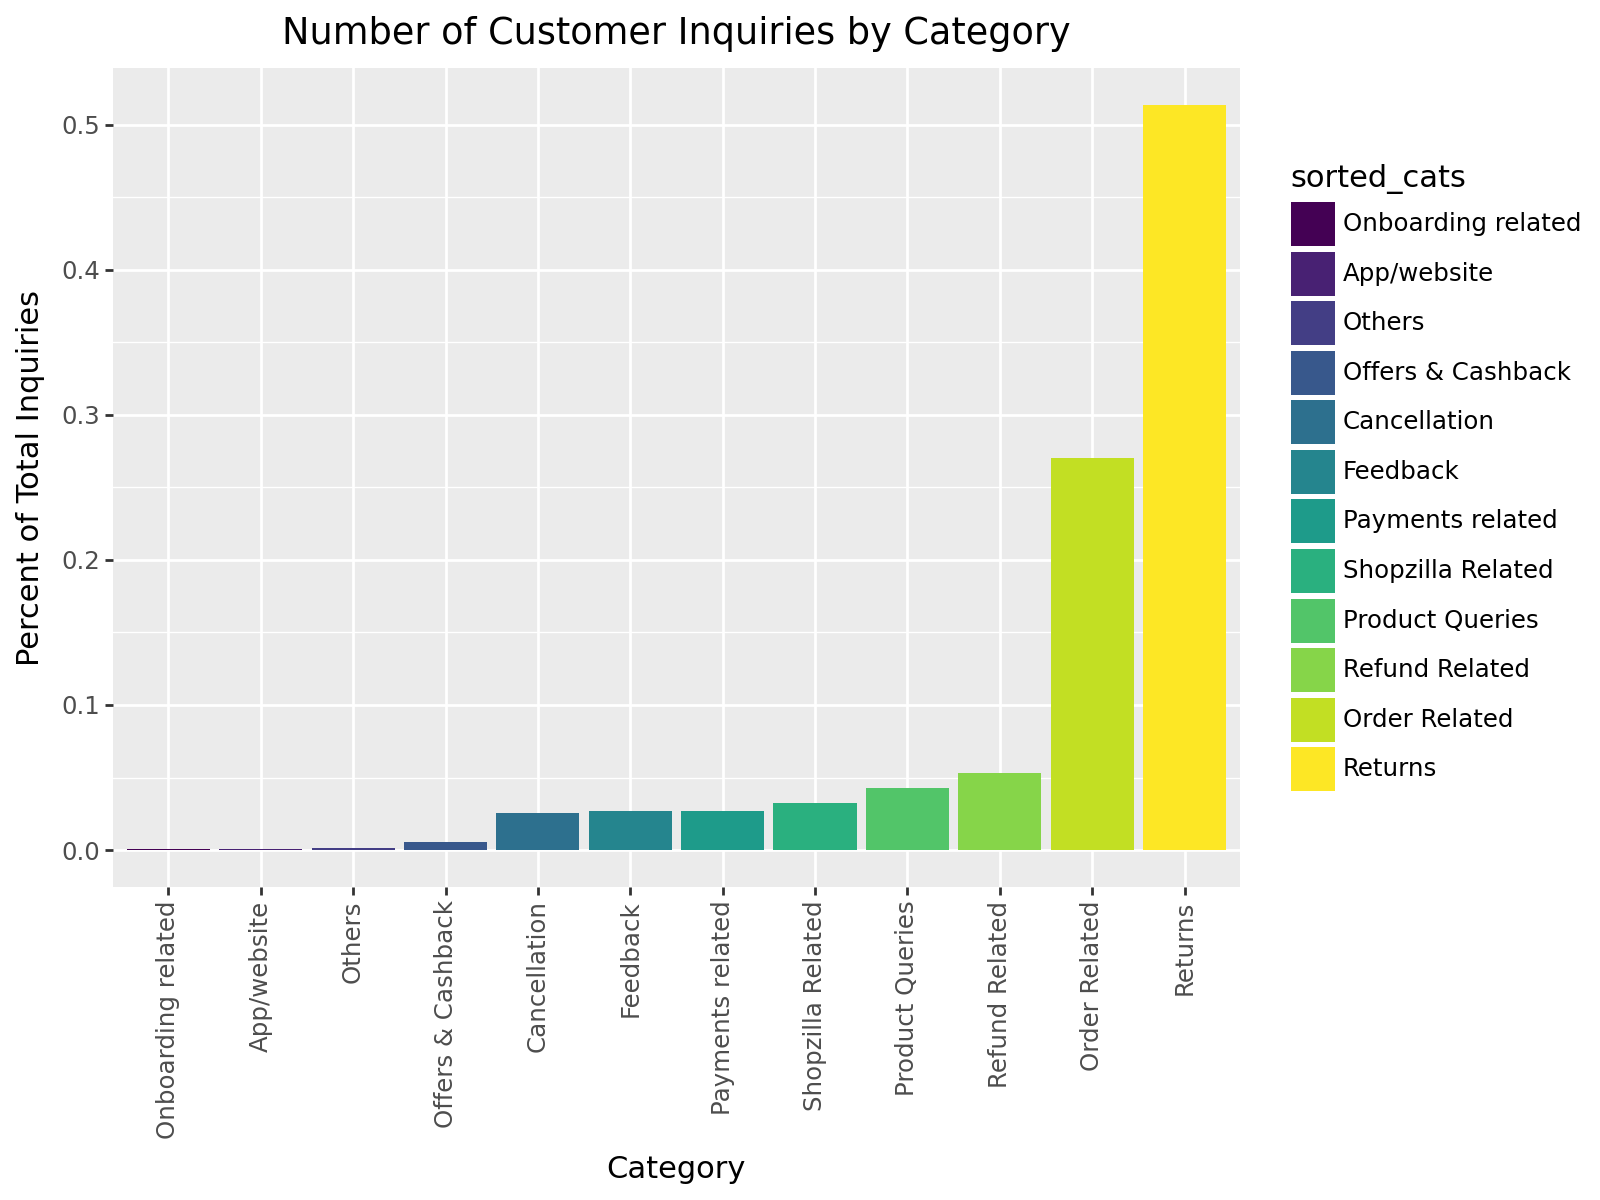

In [31]:
(
    ggplot(temp_df)
    + aes(x='sorted_cats',y='pct_total', fill='sorted_cats')
    + geom_bar(stat='identity')
    + theme(axis_text_x=element_text(rotation=90), figure_size=(8,6))
    + labs(title="Number of Customer Inquiries by Category", x='Category',y='Percent of Total Inquiries')
)

Basedd on our data, we see that the overwhelming number of customer inquiries are in the category Returns and Order Related. These two categories account for 80% of all customer inquiries

##### *3.7 Number of Issues by Shift*

In [32]:
pd.DataFrame(cust_satisfaction_df['agent_shift'].value_counts()).reset_index()

,agent_shift,count
0,Morning,41426
1,Evening,33677
2,Afternoon,5840
3,Split,3648
4,Night,1316


One final set of analysis is to see the distribution of the time it takes to resolve an issue in days and in minutes

##### 3.8 Distribution of Issues by Resolution Time

In [33]:
temp_df = cust_satisfaction_df.loc[cust_satisfaction_df['response_time_days'] >= 0].copy()
temp_df['response_time_days'] = temp_df['response_time_days'].astype('category')

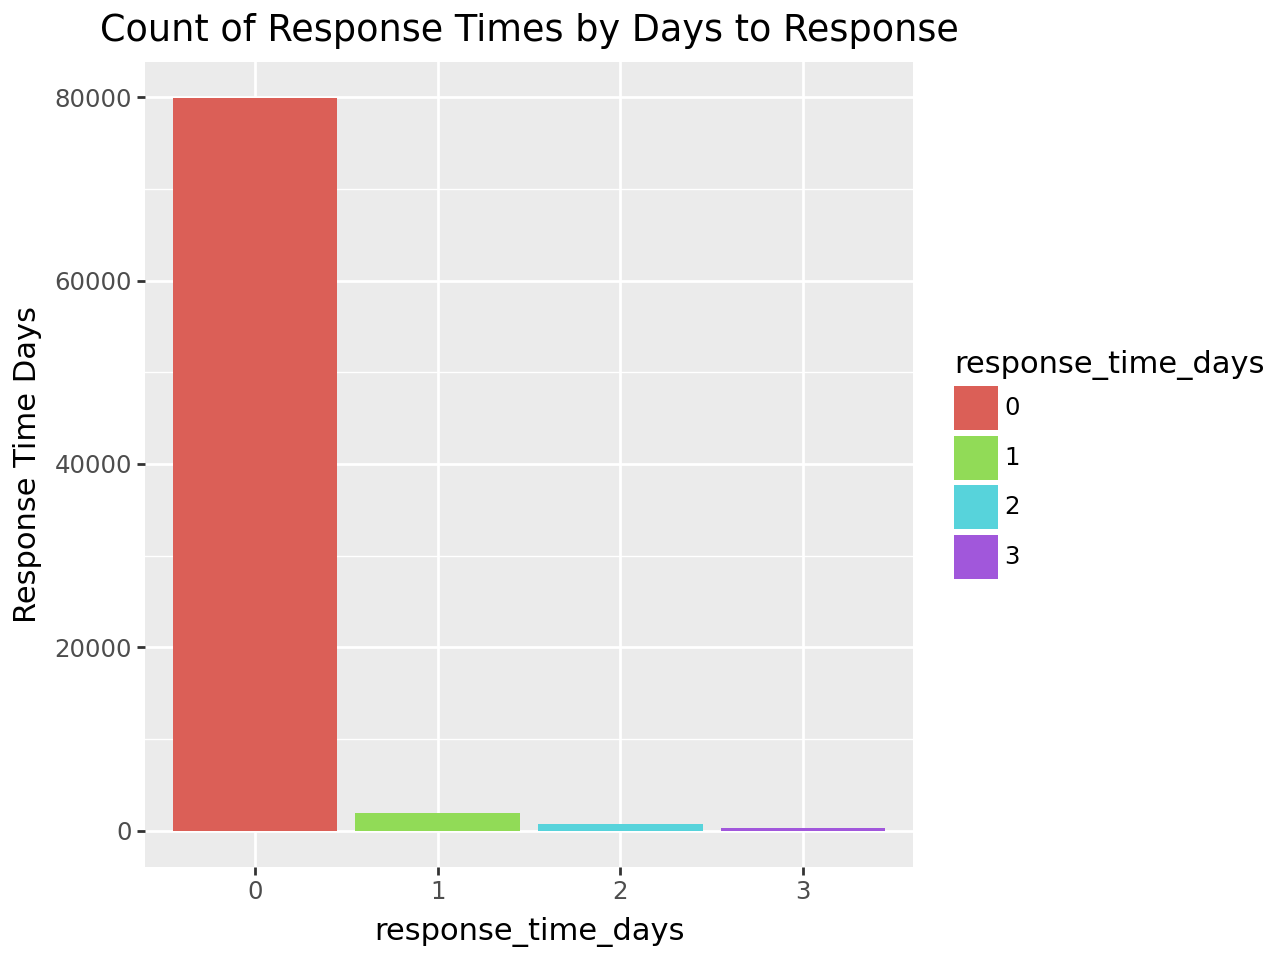

In [34]:

(
    ggplot(temp_df)
    + aes(x='response_time_days', fill='response_time_days')
    + geom_bar() 
    + labs(title='Count of Response Times by Days to Response', y='Response Time Days')
)

We see that there's a dramatic change in the csat score when we go from a same-day response time to a longer period.

In [35]:
temp_df2 = temp_df.pivot_table(index='response_time_days', values=['csat_score']).reset_index().copy()

In [36]:
temp_df2

,response_time_days,csat_score
0,0,4.267028
1,1,3.477152
2,2,3.278426
3,3,3.150160


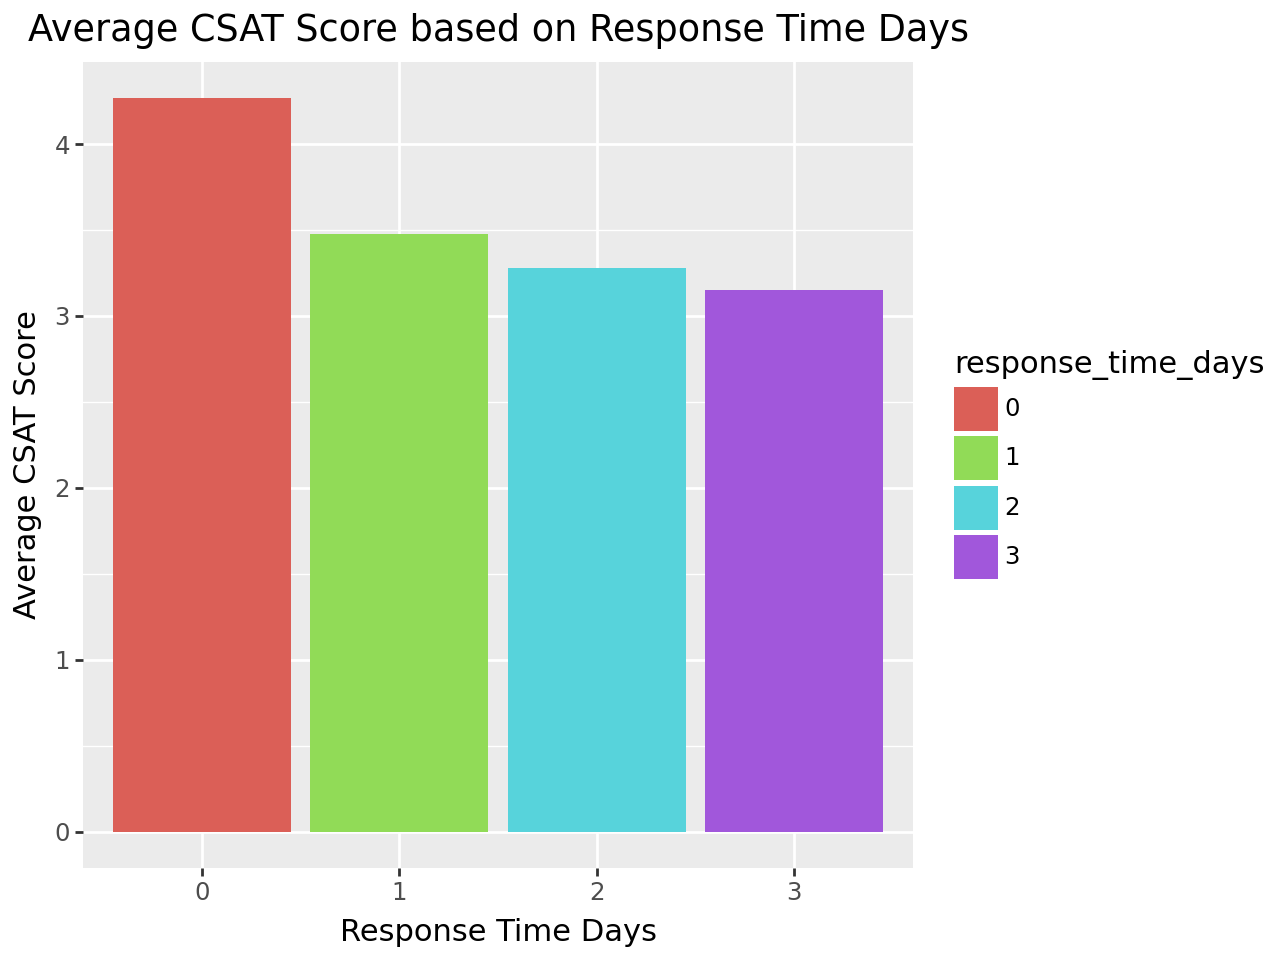

In [37]:
(
    ggplot(temp_df2)
    + aes(x='response_time_days', y='csat_score', fill='response_time_days')
    + geom_bar(stat='identity') 
    + labs(title="Average CSAT Score based on Response Time Days", x='Response Time Days', y='Average CSAT Score')
)

We see that the Morning shift is a heavy period for customer inquiries, which makes more sense as to why we would see that the customer satisfaction scores would be lower during that period

#### **4. Machine Learning**


Our pre-processing is focused on simplifying our dataframe to only include the features that I feel are actually relevant to the problem of predicting the CSAT score. 
For the machine learning portion, we are going to build a decision tree to predict the CSAT Score. Before we do this, we'll need to do some pre-processing to develop a data set that is best equipped to handle this request

In [38]:
cust_satisfaction_df.head()

,unique_id,channel_name,category,sub_category,customer_remarks,order_id,order_date_time,issue_reported_at,issue_responded,survey_response_date,...,supervisor,manager,tenure_bucket,agent_shift,csat_score,order_date,response_date,issue_date,response_time_days,response_time_minutes
0,7e9ae164-6a8b-4521-a2d4-58f7c9fff13f,Outcall,Product Queries,Life Insurance,NaN,c27c9bb4-fa36-4140-9f1f-21009254ffdb,NaN,01/08/2023 11:13,01/08/2023 11:47,01-Aug-23,...,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,5,NaT,2023-08-01 11:47:00,2023-08-01 11:13:00,0,34.0
1,b07ec1b0-f376-43b6-86df-ec03da3b2e16,Outcall,Product Queries,Product Specific Information,NaN,d406b0c7-ce17-4654-b9de-f08d421254bd,NaN,01/08/2023 12:52,01/08/2023 12:54,01-Aug-23,...,Dylan Kim,Michael Lee,>90,Morning,5,NaT,2023-08-01 12:54:00,2023-08-01 12:52:00,0,2.0
2,200814dd-27c7-4149-ba2b-bd3af3092880,Inbound,Order Related,Installation/demo,NaN,c273368d-b961-44cb-beaf-62d6fd6c00d5,NaN,01/08/2023 20:16,01/08/2023 20:38,01-Aug-23,...,Jackson Park,William Kim,On Job Training,Evening,5,NaT,2023-08-01 20:38:00,2023-08-01 20:16:00,0,22.0
3,eb0d3e53-c1ca-42d3-8486-e42c8d622135,Inbound,Returns,Reverse Pickup Enquiry,NaN,5aed0059-55a4-4ec6-bb54-97942092020a,NaN,01/08/2023 20:56,01/08/2023 21:16,01-Aug-23,...,Olivia Wang,John Smith,>90,Evening,5,NaT,2023-08-01 21:16:00,2023-08-01 20:56:00,0,20.0
4,ba903143-1e54-406c-b969-46c52f92e5df,Inbound,Cancellation,Not Needed,NaN,e8bed5a9-6933-4aff-9dc6-ccefd7dcde59,NaN,01/08/2023 10:30,01/08/2023 10:32,01-Aug-23,...,Austin Johnson,Michael Lee,0-30,Morning,5,NaT,2023-08-01 10:32:00,2023-08-01 10:30:00,0,2.0


Here we list out the different variables and their index so we can easily remove them from our simplified dataframe

In [39]:
pd.DataFrame(cust_satisfaction_df.columns)

,0
0,unique_id
1,channel_name
2,category
3,sub_category
4,customer_remarks
5,order_id
6,order_date_time
7,issue_reported_at
8,issue_responded
9,survey_response_date


In [40]:
keep_cols = [1,2,3,10,11,14,15,16,17,18,23,24,19]

In [41]:
csat_df = cust_satisfaction_df.iloc[:,keep_cols]

In [42]:
csat_df.head(5)

,channel_name,category,sub_category,customer_city,product_category,agent_name,supervisor,manager,tenure_bucket,agent_shift,response_time_days,response_time_minutes,csat_score
0,Outcall,Product Queries,Life Insurance,NaN,NaN,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,0,34.0,5
1,Outcall,Product Queries,Product Specific Information,NaN,NaN,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,0,2.0,5
2,Inbound,Order Related,Installation/demo,NaN,NaN,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,0,22.0,5
3,Inbound,Returns,Reverse Pickup Enquiry,NaN,NaN,Patrick Flores,Olivia Wang,John Smith,>90,Evening,0,20.0,5
4,Inbound,Cancellation,Not Needed,NaN,NaN,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,0,2.0,5


Now I'll make a few additional modififications to the simplified dataframe. 

1. customer_city --> Remove this field since it has a lot of NA values
2. item_price --> Remove this field since it had a lot of NA values
3. product_category --> Remove this field since it has a lot of NA values
4. csat_score --> Change to categorical
5. response_time_days --> remove the values that are < 0

In [43]:
csat_df_mod = csat_df.loc[:,~csat_df.columns.isin(['customer_city','item_price','product_category'])].copy()

In [44]:
csat_df_mod.head()

,channel_name,category,sub_category,agent_name,supervisor,manager,tenure_bucket,agent_shift,response_time_days,response_time_minutes,csat_score
0,Outcall,Product Queries,Life Insurance,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,0,34.0,5
1,Outcall,Product Queries,Product Specific Information,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,0,2.0,5
2,Inbound,Order Related,Installation/demo,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,0,22.0,5
3,Inbound,Returns,Reverse Pickup Enquiry,Patrick Flores,Olivia Wang,John Smith,>90,Evening,0,20.0,5
4,Inbound,Cancellation,Not Needed,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,0,2.0,5


In [45]:
csat_df_mod.shape

(85907, 11)

As mentioned before, we will now create a variable that represents the time to response

In [46]:
csat_df_mod = csat_df_mod.loc[csat_df_mod['response_time_days'] >= 0].copy()

Finnaly, we will convert our **csat_score** variable into a categorical variable

In [47]:
csat_df_mod['csat_score'] = pd.Categorical(csat_df_mod['csat_score'])

In [48]:
csat_df_mod.head(8)

,channel_name,category,sub_category,agent_name,supervisor,manager,tenure_bucket,agent_shift,response_time_days,response_time_minutes,csat_score
0,Outcall,Product Queries,Life Insurance,Richard Buchanan,Mason Gupta,Jennifer Nguyen,On Job Training,Morning,0,34.0,5
1,Outcall,Product Queries,Product Specific Information,Vicki Collins,Dylan Kim,Michael Lee,>90,Morning,0,2.0,5
2,Inbound,Order Related,Installation/demo,Duane Norman,Jackson Park,William Kim,On Job Training,Evening,0,22.0,5
3,Inbound,Returns,Reverse Pickup Enquiry,Patrick Flores,Olivia Wang,John Smith,>90,Evening,0,20.0,5
4,Inbound,Cancellation,Not Needed,Christopher Sanchez,Austin Johnson,Michael Lee,0-30,Morning,0,2.0,5
5,Email,Returns,Fraudulent User,Desiree Newton,Emma Park,John Smith,0-30,Morning,0,206.0,5
6,Outcall,Product Queries,Product Specific Information,Shannon Hicks,Aiden Patel,Olivia Tan,>90,Morning,0,501.0,5
7,Inbound,Returns,Exchange / Replacement,Laura Smith,Evelyn Kimura,Jennifer Nguyen,On Job Training,Evening,0,6.0,5


#### 4.1 Decision Tree

In [88]:
X = csat_df_mod.iloc[:,~csat_df_mod.columns.isin(['csat_score'])]
X_mod = X.iloc[:,[0,1,6,7,8,9]].copy()
y = csat_df_mod['csat_score']
X_dummies = pd.get_dummies(X_mod,dtype='int')
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y,test_size=0.7)

In [90]:
dt_clf = DecisionTreeClassifier(min_samples_split=5, random_state=1211)
dt_clf.fit(X_train,y_train)

DecisionTreeClassifier(min_samples_split=5, random_state=1211)

In [91]:
dt_clf.score(X_test, y_test)

0.6083767645739137

In [92]:
dt_clf.get_depth()

43

#### 4.2 Random Forest

In [93]:
rf_clf = RandomForestClassifier(n_estimators = 50, random_state=1211)
rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)


0.6263762813654091

#### 4.3 Support Vector Machine

In [94]:
svm_clf = make_pipeline(StandardScaler(),LinearSVC(max_iter=1000000, random_state=1211,multi_class='crammer_singer',dual=False))
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test)

0.6939391847582231

#### 5. Conclusion & Writeup

##### _Review of Essays_
In the first article titled “Decision Tree Ensembles to Predict Coronavirus Disease 2019 Infection: A Comparative Study”, the author explores how decision trees can be used in predicting COVID-19 infections and highlights the challenges of making predictions on imbalanced datasets, where the number of positive cases is significantly lower than the number of negative cases. In this article we are reminded of the fact that decision tree ensembles are robust and perform well on imbalanced datasets, and that different ensembles - like Random Forest, XGBoost, and others - generally outperform standard decision tree models. 

In the second article titled “A novel approach to predict COVID-19 using support vector machine”, we see an example of how support vector machines (SVM) can be used to predict COVID-19 infections, by classifying cases into three categories: not infected, mildly infected, and severely infected, based on a selected set of symptoms and their severity. When compared to other machine learning models, we find that the SVM model is highlighted as superior in handling the prediction task due to its effective handling of the high-dimensional space and the critical nature of the disease symptoms.

Currently I work in the area of marketing and as an analyst I’m oftentimes looking at ways to explain relationships between various marketing tactics and customer features that can help to drive us towards our desired marketing outcomes - such as acquiring new customers, driving increased engagement, and retaining customers. In the three articles that I selected, the authors explored the use of machine learning in general and in some instances SVMs in particular to address certain key aspects found in this domain.

In the first article titled "Using Support Vector Machines for Survey Research", we see a detailed introduction to the application of Support Vector Machines (SVMs) in survey research, focusing on their usefulness in classifying binary outcomes such as survey participation. The author’s state that SVMs have been particularly useful in survey research for predicting responses and non-responses, offering a solid alternative to traditional logistic regression, where they’ve been shown to achieve superior performance in terms of classification accuracy and handling unbalanced data. Furthermore, they express that while SVMs can be considered versatile - unlike some other machine learning methods that may rely on local minima, they can be computationally intensive and appear as "black boxes" because they do not provide a straightforward functional form or coefficients for interpretation.

The second article that I reviewed related to machine learning and SVMs in the marketing domain, was titled “Machine learning and marketing” and it explored the application of machine learning techniques in marketing, and provided an overview of the distinct advantages of using ML over traditional econometric methods primarily in predictive tasks. It suggests that ML is well-suited for making accurate out-of-sample predictions, which is crucial in marketing for tasks like ad targeting and product recommendations. In exploring the application of decision trees and SVMs in this area, the article does a good job of discussing their respective benefits in handling various types of data and modeling scenarios.

In the final article titled "Customer Response Model in Direct Marketing: Solving the Problem of Unbalanced Dataset with a Balanced Support Vector Machine”, we see an example of how SVMs can be used to address the challenge of unbalanced datasets in customer response models used in direct marketing. These models, which are crucial for targeting customers likely to respond to marketing campaigns, often suffer from an imbalance where few customers respond positively compared to the majority who do not, thus potentially skewing the model’s accuracy and effectiveness. The authors’ propose using a Balanced Support Vector Machine (B-SVM) approach, which involves a combination of random undersampling and SVM classification, which they are able to use to significantly improve the predictive performance of base models used in customer response predictions based on metrics like accuracy, sensitivity, and the Area Under Curve (AUC). The application of these findings can be particularly relevant for online marketing efforts, as they provide a more efficient way to target potential customers, potentially increasing campaign profitability while reducing marketing costs due to more precise targeting.



##### _Exploratory Analysis_
For this assignment, I used a e-Commerce Customer Satisfaction dataset obtained from Kaggle. This dataset had 85K records and 20 features, with each record providing the customer satisfaction scores for a specific customer inquiry. The data was relatively rich with a number of useful qualitative variables that could be used to highlight potential sources of difference in the CSAT scores that were generated.

Prior to doing some exploratory analysis, I created three additional variables order_date, response_date and issue_date, to convert the existing date type variables from their day-month-year format into the more common (in the US) date format of month-day-year. This also was done to allow for the creation of a response_time variable to represent the number of days before an issue was responded to and/or resolved.

For the exploratory analysis, I focused on looking at the relationship between the CSAT scores and the different qualitative variables in the dataset. As shown in the notebook, there appears to be some level of variation in the average CSAT scores based on the customer issue type, with average scores ranging from a high of 4.4 to a low of 3.4. Additionally, the Supervisor of an agent also appears to be a source of variation in the average CSAT score, with supervisors whose agents are in the top 10 average scores having a group average of 4.4 vs those in the bottom 10, whose average score is 4.0. Finally, another very interesting observation is the impact that time to response (days) has on the average CSAT score. For issues that are responded to within a 24-hour period, the average CSAT score is 4.3. However, if we get past this 24-hour window, the average CSAT score plummets to 3.5 if it takes one day to respond. Luckily, based on the distribution of response times, nearly all of the issues have a same-day response time.



##### _Model Evaluation_
Finally, for the machine Learning model, I reduced the features to just the following:
- channel_name 
- category 
- tenure_bucket
- agent_shift
- response_time_days
- response_time_minutes

Next I created dummy variables for the category, channel_name, tenure_bucket and agent_shift variables.

Finally, I started by training and evaluating a standard decision tree and a random forrest decision tree model. With the standard model, we achieved an accuracy score of 60.8%, while the random forrest model had an improved accuracy score of 62.6%. Finally, I ran a LinearSVM model and the accuracy improved to 69.4%.

Overall, it appears that the SVM model did a better job at generating more accurate results compared to the decision tree algorithms. Furthermore, the improve in the accuracy - by nearly 10 percentage points is a significant improvement in the performance, while there was not any significant changes in the amount of time it took to achieve these results. I think that SVM models can do a much better job at generating accurate predictions versus standard decision trees or random forests.